In [1]:
using DrWatson

@quickactivate "GRNEvoContingency"

projectname()

"GRNEvoContingency"

In [2]:
include(srcdir("TissueModel_ND.jl"))

include(srcdir("Evolution.jl"))
include(srcdir("FitnessFunctions.jl"))

include(srcdir("NetworkTopologies.jl"))
include(srcdir("Utility.jl"))

using Plots
using Random
using Parameters
using Printf
using DataFrames
using GraphRecipes
using JLD
using StatsPlots

example_networks = load(datadir("exp_pro/80-40-80_networks/examples.jld"))

Dict{String, Any} with 6 entries:
  "bistable"     => NaN
  "feed_forward" => [0.0 0.0 0.0 0.19495; 0.173532 0.0 0.0 0.0; 3.02262 -5.5322…
  "classical"    => [0.0 0.0 0.0 0.114353; -0.560775 0.359711 0.0 0.0; -0.07258…
  "frozen_osc"   => NaN
  "mutual_inh"   => [0.0 0.0 0.0 0.2454; 0.455819 0.0 -2.23319 0.0; 0.446651 -2…
  "overlap_dom"  => [0.0 0.0 -0.00379469 0.228214; 0.653415 0.0 0.0 0.0; -0.424…

In [3]:
df = collect_results(datadir("sims/repeated_evolution_different_topologies"));

┌ Info: Scanning folder /Users/boothh/Documents/GRNEvoContingency/data/sims/repeated_evolution_different_topologies for result files.
└ @ DrWatson /Users/boothh/.julia/packages/DrWatson/UkasH/src/result_collection.jl:115
┌ Info: Added 8 entries.
└ @ DrWatson /Users/boothh/.julia/packages/DrWatson/UkasH/src/result_collection.jl:191


In [4]:
headings = ["topology",
            "target",
            "n_traj",
            "max_gen",
            "β",
            "noise_cv",
            "mutation_method",
            "noise_method",
            "n_max_iters_reached",
            "describe_proportion_mutants_rejected"];

In [5]:
df[:,headings]

Row,topology,target,n_traj,max_gen,β,noise_cv,mutation_method,noise_method,n_max_iters_reached,describe_proportion_mutants_rejected
,String?,Array…?,Int64?,Int64?,Float64?,Float64?,String?,String?,Int64?,SummaryS…?
1,classical,"[(40.0, 20.0)]",100,20000,Inf,1.0,all_viable,additive,0,Summary Stats:\nLength: 100\nMissing Count: 0\nMean: 0.018348\nMinimum: 0.001850\n1st Quartile: 0.012676\nMedian: 0.016801\n3rd Quartile: 0.020967\nMaximum: 0.075696\n
2,feed_forward,"[(40.0, 20.0)]",100,20000,Inf,1.0,all_viable,additive,0,Summary Stats:\nLength: 100\nMissing Count: 0\nMean: 0.019802\nMinimum: 0.000000\n1st Quartile: 0.000669\nMedian: 0.012043\n3rd Quartile: 0.035063\nMaximum: 0.097395\n
3,mutual_inh,"[(40.0, 20.0)]",100,20000,Inf,1.0,all_viable,additive,0,Summary Stats:\nLength: 100\nMissing Count: 0\nMean: 0.020275\nMinimum: 0.001313\n1st Quartile: 0.017634\nMedian: 0.020514\n3rd Quartile: 0.023056\nMaximum: 0.032863\n
4,overlap_dom,"[(40.0, 20.0)]",100,20000,Inf,1.0,all_viable,additive,0,Summary Stats:\nLength: 100\nMissing Count: 0\nMean: 0.012762\nMinimum: 0.000000\n1st Quartile: 0.000366\nMedian: 0.004846\n3rd Quartile: 0.017632\nMaximum: 0.240788\n
5,classical,"[(40.0, 20.0)]",2500,20000,Inf,1.0,all_viable,additive,0,Summary Stats:\nLength: 2500\nMissing Count: 0\nMean: 0.022178\nMinimum: 0.000000\n1st Quartile: 0.000000\nMedian: 0.004796\n3rd Quartile: 0.028302\nMaximum: 0.560301\n
6,feed_forward,"[(40.0, 20.0)]",2500,20000,Inf,1.0,all_viable,additive,0,Summary Stats:\nLength: 2500\nMissing Count: 0\nMean: 0.156745\nMinimum: 0.000000\n1st Quartile: 0.089655\nMedian: 0.128423\n3rd Quartile: 0.194289\nMaximum: 0.897805\n
7,mutual_inh,"[(40.0, 20.0)]",2500,20000,Inf,1.0,all_viable,additive,0,Summary Stats:\nLength: 2500\nMissing Count: 0\nMean: 0.109172\nMinimum: 0.000000\n1st Quartile: 0.050000\nMedian: 0.084526\n3rd Quartile: 0.126080\nMaximum: 0.836708\n
8,overlap_dom,"[(40.0, 20.0)]",2500,20000,Inf,1.0,all_viable,additive,0,Summary Stats:\nLength: 2500\nMissing Count: 0\nMean: 0.206376\nMinimum: 0.000000\n1st Quartile: 0.126624\nMedian: 0.193882\n3rd Quartile: 0.266872\nMaximum: 0.725014\n


In [6]:
df_current = filter(:n_traj=>x->x==2500,df);

In [7]:
evolutionary_runs = Dict{String,Any}("classical"=>df_current[:,"raw_data"][1],"feed_forward"=>df_current[:,"raw_data"][2],"mutual_inh"=>df_current[:,"raw_data"][3],"overlap_dom"=>df_current[:,"raw_data"][4]);

In [8]:
matrix_entries = [(1,1),(2,1),(3,1),(1,2),(2,2),(3,2),(1,3),(2,3),(3,3),(1,4),(2,4),(3,4)];

In [9]:
topology = "overlap_dom"
raw_data = evolutionary_runs[topology];
start_network = example_networks[topology];

In [10]:
reshape(start_network,12)

12-element Vector{Float64}:
  0.0
  0.653414941936679
 -0.42453295521991624
  0.0
  0.0
  0.1500293447611271
 -0.0037946873672191623
  0.0
  0.0
  0.22821365435451213
  0.0
  0.0

In [13]:
final_plot_list = []


topology_list = ["classical","overlap_dom","feed_forward","mutual_inh"]

for topology in topology_list

    raw_data = evolutionary_runs[topology]
    start_network = example_networks[topology]

    all_w = map(x->x[1].dominant_individual.genotype.p[1],raw_data);

    weight_counts = zeros(length(all_w),12)

    for s in 1:length(all_w)
        for wi in 1:12
            weight_counts[s,wi] = reshape(all_w[s],12)[wi]
        end
    end

    plot_list = []

    start_network_flattened = reshape(start_network,(1,12))

    for i in [1,4,7,10,2,5,8,11,3,6,9,12]
        if i in [11,12]
            p = plot(legend=false,grid=false,foreground_color_subplot=:white)
        else
            p = histogram(filter(x->x!=0,weight_counts[:,i:i]),bins = 50,size = (1000,800),title = matrix_entries[i],label = false)
            vline!(p,[start_network_flattened[i]],linewidth = 2.,label = false)
        end
        push!(plot_list,p)
    end

    f = plot(plot_list...,layout = 12,size = (1500,750))
    
    push!(final_plot_list,f)
end

In [15]:
for i in 1:4
    savefig(final_plot_list[i],plotsdir("Figures",topology_list[i] * " weight_hist.png"))
end

In [14]:
w_vec(w) = reverse(vec(Int.(sign.(w) .+ 1)))
vec_b3(v) = foldl((x,y) -> 3*x+y, v)

w_b3(w) = vec_b3(w_vec(w))

w_b3 (generic function with 1 method)

In [15]:
topology_exp = Dict{String,Any}()

for topology in ["classical","overlap_dom","feed_forward","mutual_inh"]

    raw_data = evolutionary_runs[topology]
    start_network = example_networks[topology]

    all_w = map(x->x[1].dominant_individual.genotype.p[1],raw_data);

    start_vec = w_vec(start_network)

    start_topology = w_b3(start_network)

    end_topologies = map(x->w_b3(x),all_w);

    end_distances = map(x->hamming(w_vec(x),start_vec),all_w);

    end_top_distances = map(x->(w_b3(x),hamming(w_vec(x),start_vec)),all_w)

    topology_exp[topology] = end_topologies

end

In [16]:
# final_topologies = unique(reduce(vcat,[topology_exp["feed_forward"],topology_exp["classical"],topology_exp["overlap_dom"],topology_exp["mutual_inh"]]))

# final_topologies = unique(reduce(vcat,[collect(keys(filter(x->x[2] > 10, countmap(topology_exp["feed_forward"])))),
#                                         collect(keys(filter(x->x[2] > 10, countmap(topology_exp["classical"])))),
#                                         collect(keys(filter(x->x[2] > 10, countmap(topology_exp["overlap_dom"])))),
#                                         collect(keys(filter(x->x[2] > 10, countmap(topology_exp["mutual_inh"]))))]))

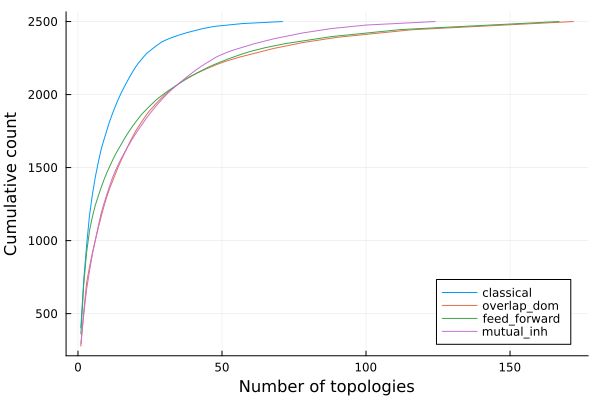

In [32]:
f = plot()
total_list = []
for topology in ["classical","overlap_dom","feed_forward","mutual_inh"]

    start_network = example_networks[topology]
    start_topology = w_b3(start_network)

    topology_count = countmap(topology_exp[topology])
    total = reverse(map(x->x[2],sort(collect(topology_count), by=x->x[2])))
    push!(total_list,sort(collect(topology_count), by=x->x[2]))
    # findall(x-> x== start_topology,total)
    plot!(f,cumsum(total),label = topology,legend=:bottomright)
end

xaxis!(f,"Number of topologies")
yaxis!(f,"Cumulative count")

In [74]:
figure_list =  []

n = 10

for topology in ["classical","overlap_dom","feed_forward","mutual_inh"]

    start_network = example_networks[topology]
    start_topology = w_b3(start_network)

    topology_count = countmap(topology_exp[topology])

    r = sort(collect(topology_count), by=x->x[2])

    results = DataFrame(:ID => map(x->x[1],r),:Count => map(x->x[2],r))

    f = bar(results[end-(n-1):end,:Count],xticks = (1:n,results[end-(n-1):end,:ID]),legend = :topright,ylabel = "Count", xlabel = "Topology id",titlefontsize = 8.,label = false,title = topology * " : " * string(start_topology))

    push!(figure_list,f)
end

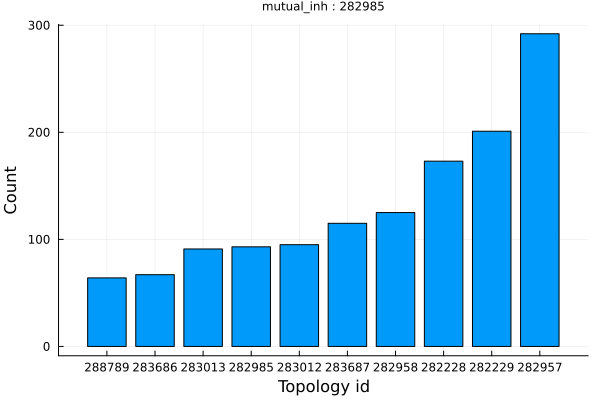

In [79]:
figure_list[4]

In [71]:
topology_count = countmap(topology_exp["mutual_inh"])

r = sort(collect(topology_count), by=x->x[2])

124-element Vector{Pair{Int64, Int64}}:
 276532 => 1
 289491 => 1
 289601 => 1
 288871 => 1
 288709 => 1
 288763 => 1
 289546 => 1
 282337 => 1
 275614 => 1
 275749 => 1
        ⋮
 283686 => 67
 283013 => 91
 282985 => 93
 283012 => 95
 283687 => 115
 282958 => 125
 282228 => 173
 282229 => 201
 282957 => 292

In [127]:
topologies = ["classical","overlap_dom","feed_forward","mutual_inh"]
w = zeros(4,4)
for i in 1:4
    for j in 1:4
        w[i,j] = length(intersect(Set(topology_exp[topologies[i]]),Set(topology_exp[topologies[j]]))) / length(Set(topology_exp[topologies[i]]))
    end
end


topologies = ["classical","overlap_dom","feed_forward","mutual_inh"]
w_ham = zeros(4,4)
for i in 1:4
    start_i = w_vec(example_networks[topologies[i]])
    for j in 1:4
        start_j = w_vec(example_networks[topologies[j]])
        w_ham[i,j] = hamming(start_i,start_j)
    end
end


In [128]:
w

4×4 Matrix{Float64}:
 1.0  0.0  0.0       0.0
 0.0  1.0  0.0       0.0
 0.0  0.0  1.0       0.203593
 0.0  0.0  0.274194  1.0

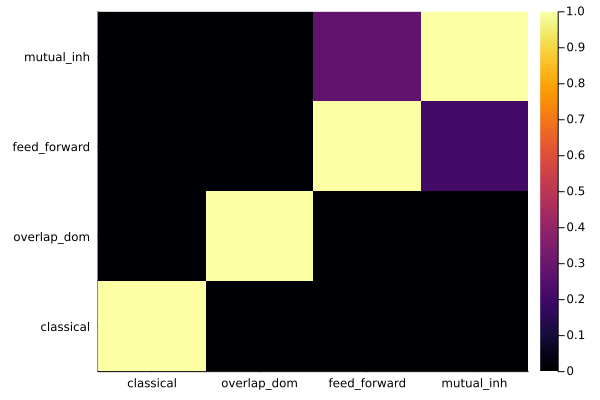

In [129]:
heatmap(w,xticks = (1:4, topologies),yticks = (1:4, topologies))


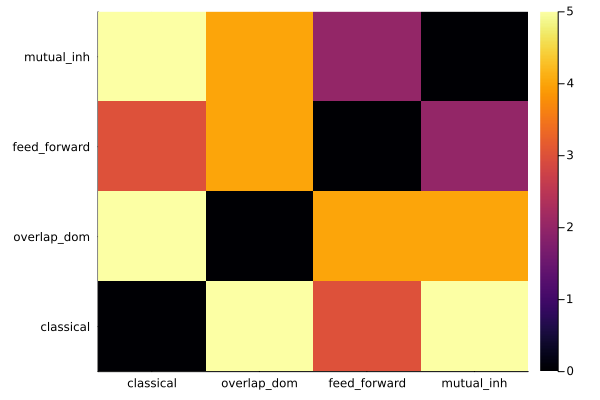

In [130]:
heatmap(w_ham,xticks = (1:4, topologies),yticks = (1:4, topologies))

In [133]:
shared_top = collect(intersect(Set(topology_exp["mutual_inh"]),Set(topology_exp["feed_forward"])))

34-element Vector{Int64}:
 288736
 275614
 289572
 276478
 276315
 288790
 276532
 288816
 289600
 276450
      ⋮
 288844
 289573
 275668
 289519
 289599
 288817
 289520
 289545
 289546

In [135]:
filter(x->x[1] in shared_top,countmap(topology_exp["mutual_inh"]))

Dict{Int64, Int64} with 34 entries:
  288736 => 1
  275614 => 1
  289572 => 7
  276478 => 4
  276315 => 6
  288790 => 33
  276532 => 1
  288816 => 3
  289600 => 5
  276450 => 3
  290247 => 13
  276316 => 2
  288789 => 64
  276397 => 58
  290248 => 26
  276477 => 3
  277207 => 2
  289518 => 29
  289438 => 3
  ⋮      => ⋮

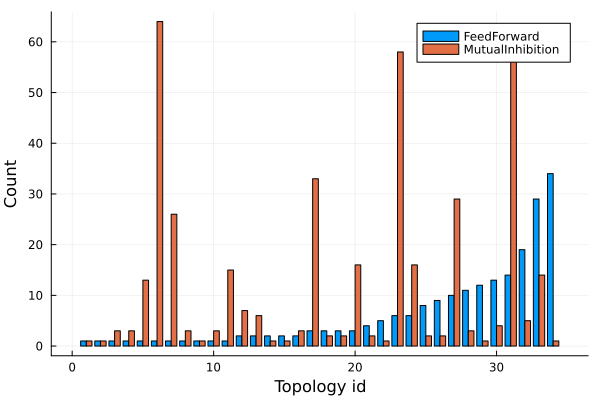

In [157]:
mi = collect(values(filter(x->x[1] in shared_top,countmap(topology_exp["mutual_inh"]))))
ff = collect(values(filter(x->x[1] in shared_top,countmap(topology_exp["feed_forward"]))))

results = DataFrame(:FeedForward=>ff,:MutualInhibition=>mi)

sort!(results, [:FeedForward])

@df results groupedbar([:FeedForward :MutualInhibition],legend = :topright, ylabel = "Count", xlabel = "Topology id",titlefontsize = 8.)